![](https://miro.medium.com/max/700/1*h0zZjCSgcjZh0Bh2T4kMDg.png)

<h1>Introduction</h1>

<h3>Dataset</h3>

*  <span><a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Link to the dataset</a></span>
*   This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.



<h3>Aim</h3>

The objective is to segment the customers based on recency, frequency and monetary so that the company is able to filter out the target audience.

<h1>Reading and Understanding Data</h1>

In [ ]:
#importing important libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
#Reading data 

# df = pd.read_csv('OnlineRetail.csv', sep=',', encoding="ISO-8859-1", header=0)
data = pd.read_csv('OnlineRetail.csv', sep=',', encoding="ISO-8859-1", header=0)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
#shape of df
data.shape

(541909, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<h1>Data Cleansing</h1>

In [ ]:
#percent contribution of missing values

data_null = round(100*(data.isnull().sum())/len(data), 2)
data_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [ ]:
data['CustomerID'].nunique()

4372

In [ ]:
data['CustomerID'].mean()

15287.690570239585

In [ ]:
data['CustomerID'].median()

15152.0

In [ ]:
data['CustomerID'].mode()

0    17841.0
dtype: float64

In [ ]:
#Dropping null values

data = data.dropna()
data.shape

(406829, 8)

In [ ]:
data['CustomerID'] = data['CustomerID'].astype(str)

<h1>Data Preparation</h1>

Analysis is going to be based on three factors:


*   R(Recency): last purchased date
*   F(Frequency): Number of transactions
*   Tr(Total Revenue): Total revenue contributed





In [ ]:
#Introducing new attribute Total revenue

data['TotalRevenue'] = data['Quantity']*data['UnitPrice']
data_m = data.groupby('CustomerID')['TotalRevenue'].sum()
data_m = data_m.reset_index()
data_m.head()

,CustomerID,TotalRevenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
data['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [ ]:
#Introducing new attribute frequency

data_f = data.groupby('CustomerID')['InvoiceNo'].count()
data_f = data_f.reset_index();
data_f.columns = ['CustomerID', 'Frequency']
data_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
#Merging the two dataframes
RFTr = pd.merge(data_f, data_m, on='CustomerID', how='inner')
RFTr.head()

,CustomerID,Frequency,TotalRevenue
0,12346.0,2,0.00
1,12347.0,182,4310.00
2,12348.0,31,1797.24
3,12349.0,73,1757.55
4,12350.0,17,334.40


In [ ]:
#Introducing new attribute recency
#Convert Invoice Date to proper datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [ ]:
#maximum date
max_date = max(data['InvoiceDate'])
#Computing difference 
data['Diff'] = max_date-data['InvoiceDate']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [ ]:
#Compute last transaction date to get recency

RFTr_r = data.groupby('CustomerID')['Diff'].min()
RFTr_r = RFTr_r.reset_index()
RFTr_r.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
#Extracting the number of days from difference

RFTr_r['Diff'] = RFTr_r['Diff'].dt.days
RFTr_r.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [ ]:
#Merging the dataframes to get final RFTr dataframe
RFTr = pd.merge(RFTr, RFTr_r, on='CustomerID', how='inner')
RFTr.columns = ['CustomerID', 'Frequency', 'TotalRevenue', 'Recency']
RFTr.head()

,CustomerID,Frequency,TotalRevenue,Recency
0,12346.0,2,0.00,325
1,12347.0,182,4310.00,1
2,12348.0,31,1797.24,74
3,12349.0,73,1757.55,18
4,12350.0,17,334.40,309


Text(0.5, 0, 'Attributes')

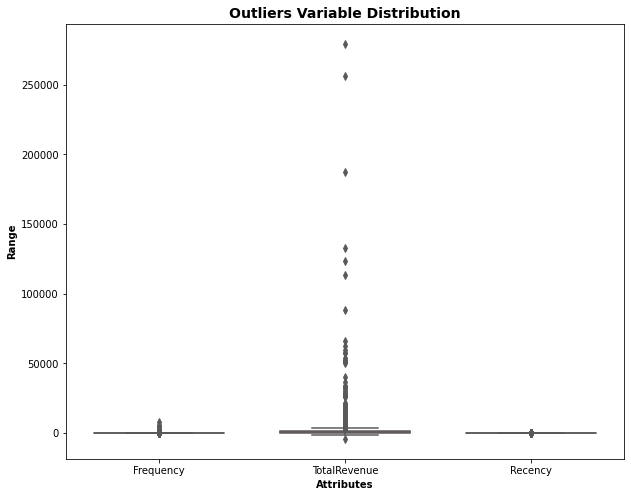

In [ ]:
#Outlier Analysis for TotalRevenue, Frequency and Recency
attributes = ['Frequency','TotalRevenue','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = RFTr[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Total Revenue
Q1 = RFTr.TotalRevenue.quantile(0.05)
Q3 = RFTr.TotalRevenue.quantile(0.95)
IQR = Q3 - Q1
RFTr = RFTr[(RFTr.TotalRevenue >= Q1 - 1.5*IQR) & (RFTr.TotalRevenue <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = RFTr.Recency.quantile(0.05)
Q3 = RFTr.Recency.quantile(0.95)
IQR = Q3 - Q1
RFTr = RFTr[(RFTr.Recency >= Q1 - 1.5*IQR) & (RFTr.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = RFTr.Frequency.quantile(0.05)
Q3 = RFTr.Frequency.quantile(0.95)
IQR = Q3 - Q1
RFTr = RFTr[(RFTr.Frequency >= Q1 - 1.5*IQR) & (RFTr.Frequency <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

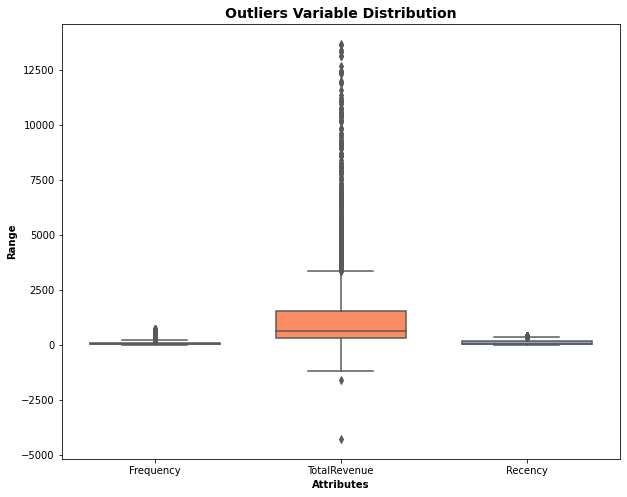

In [ ]:
# Outlier Analysis of TotalRevenue Frequency and Recency

attributes = ['Frequency','TotalRevenue','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = RFTr[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

<h1>Data Scaling</h1>
Using Standardisation Scaling


In [ ]:
#Rescaling the attributes

RFTr_df = RFTr[['Frequency', 'TotalRevenue', 'Recency']]
sc = StandardScaler()
RFTr_df_scaled = sc.fit_transform(RFTr_df)
RFTr_df_scaled.shape

(4293, 3)

In [ ]:
RFTr_df_scaled = pd.DataFrame(RFTr_df_scaled)
RFTr_df_scaled.columns = ['Frequency', 'TotalRevenue', 'Recency']
RFTr_df_scaled.head()

,Frequency,TotalRevenue,Recency
0,-0.752888,-0.723738,2.301611
1,1.042467,1.731617,-0.906466
2,-0.463636,0.300128,-0.183658
3,-0.044720,0.277517,-0.738141
4,-0.603275,-0.533235,2.143188


<h1>ML Model</h1>

<h2>K-Means Clustering</h2>

<h3>Elbow Curve</h3>

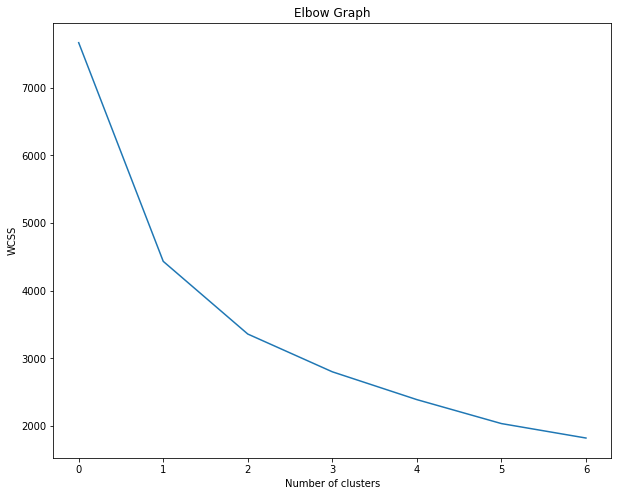

In [ ]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(RFTr_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.title('Elbow Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Final Model with k=5

kmeans = KMeans(n_clusters=5, max_iter=50)
kmeans.fit(RFTr_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1], dtype=int32)

In [ ]:
kmeans.cluster_centers_

array([[-0.51798519, -0.50219519,  1.58017996],
       [ 3.04183373,  1.4372936 , -0.7230863 ],
       [-0.38069813, -0.36364467, -0.42258795],
       [ 2.21222813,  4.46067117, -0.72395482],
       [ 0.65415302,  0.68837801, -0.61643958]])

In [ ]:
cluster_data= RFTr_df.copy()
cluster_data['cluster_pred'] = kmeans.fit_predict(RFTr_df_scaled)

In [ ]:
cluster_data.head()

,Frequency,TotalRevenue,Recency,cluster_pred
0,2,0.00,325,0
1,182,4310.00,1,4
2,31,1797.24,74,2
3,73,1757.55,18,2
4,17,334.40,309,0


In [ ]:
cluster_data.loc[cluster_data['cluster_pred']==0]

,Frequency,TotalRevenue,Recency,cluster_pred
1,182,4310.00,1,0
10,131,6207.67,32,0
12,254,6245.53,7,0
15,274,5154.58,2,0
20,167,3545.69,50,0
...,...,...,...,...
4324,299,6315.23,1,0
4326,286,5361.02,2,0
4327,245,5192.10,38,0
4330,164,7276.90,11,0


<h1>Agglomerative Clustering</h1>

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
link = linkage(RFTr_df_scaled, method = 'complete')

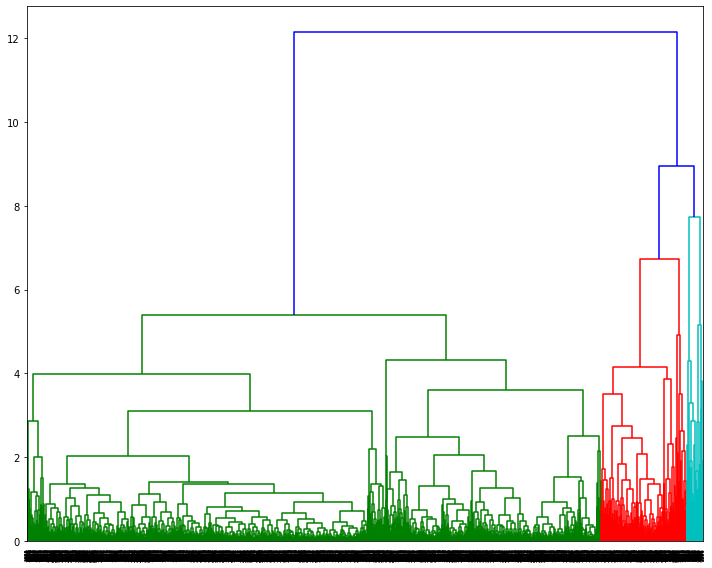

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax = dendrogram(link)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
ag_cluster = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean')

In [ ]:
ag_cluster.fit(RFTr_df_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [ ]:
cluster_data= RFTr_df.copy()
cluster_data['cluster_pred'] = ag_cluster.fit_predict(RFTr_df_scaled)

In [ ]:
cluster_data.head()

,Frequency,TotalRevenue,Recency,cluster_pred
0,2,0.00,325,0
1,182,4310.00,1,1
2,31,1797.24,74,0
3,73,1757.55,18,0
4,17,334.40,309,0


**Getting Optimal Number of Clusters**

<h3>Silhouette Analysis</h3>

In [ ]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
sa = []
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(RFTr_df_scaled)

    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(RFTr_df_scaled, cluster_labels)
    sa.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48079109657291913
For n_clusters=5, the silhouette score is 0.46481058150500315
For n_clusters=6, the silhouette score is 0.4169897163641209
For n_clusters=7, the silhouette score is 0.415966062047432
For n_clusters=8, the silhouette score is 0.39439948764516547


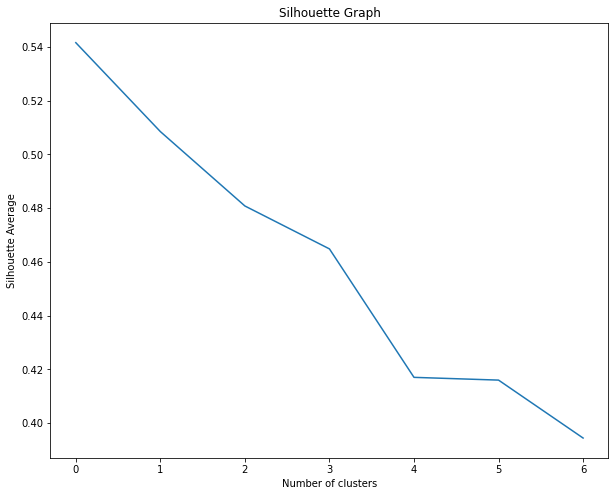

In [ ]:
# plot the Sas for each n_clusters
plt.plot(sa)
plt.title('Silhouette Graph')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Average')
plt.show()

In [ ]:
# Final model with k=2
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(RFTr_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans.labels_

array([0, 1, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
# assign the label
RFTr['Cluster_Id'] = kmeans.labels_
RFTr.head()

,CustomerID,Frequency,TotalRevenue,Recency,Cluster_Id,Cluster_Labels
0,12346.0,2,0.00,325,0,0
1,12347.0,182,4310.00,1,1,0
2,12348.0,31,1797.24,74,0,0
3,12349.0,73,1757.55,18,0,0
4,12350.0,17,334.40,309,0,0


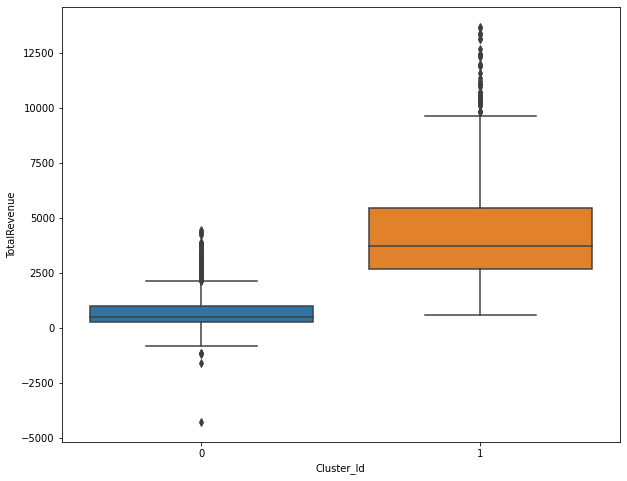

In [ ]:
# Box plot to visualize Cluster Id vs Total Revenue

sns.boxplot(x='Cluster_Id', y='TotalRevenue', data=RFTr)

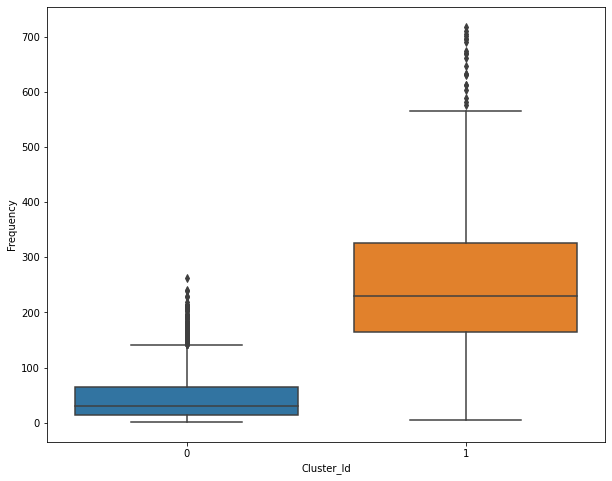

In [ ]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=RFTr)

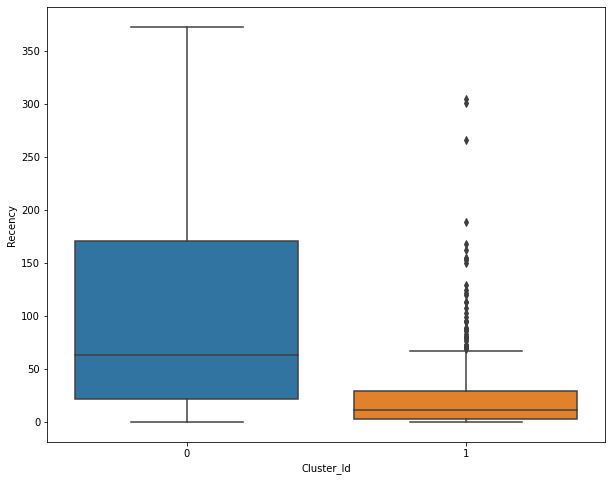

In [ ]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=RFTr)

In [ ]:
RFTr['Cluster_Id'].unique()

array([0, 1], dtype=int32)

<h1>Hierarchical Clustering</h1>

**Single Linkage**

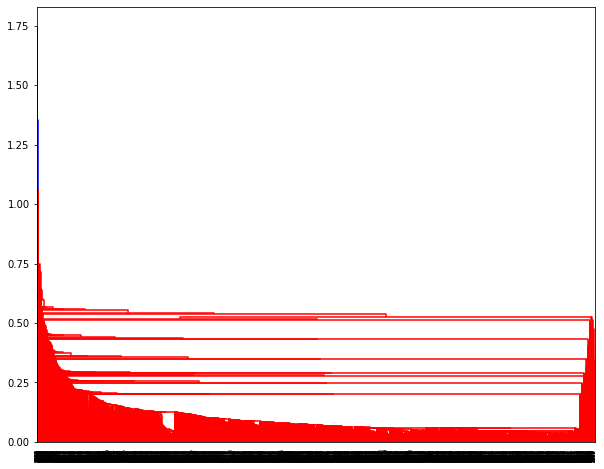

In [ ]:
# Single linkage: 

mergings = linkage(RFTr_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

**Complete Linkage**

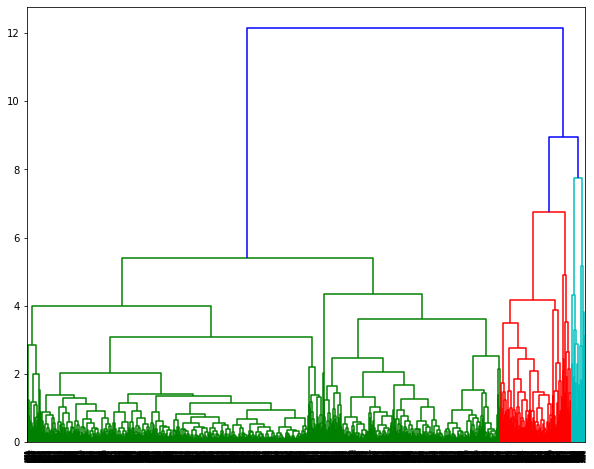

In [ ]:
# Complete linkage

mergings = linkage(RFTr_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Average Linkage**

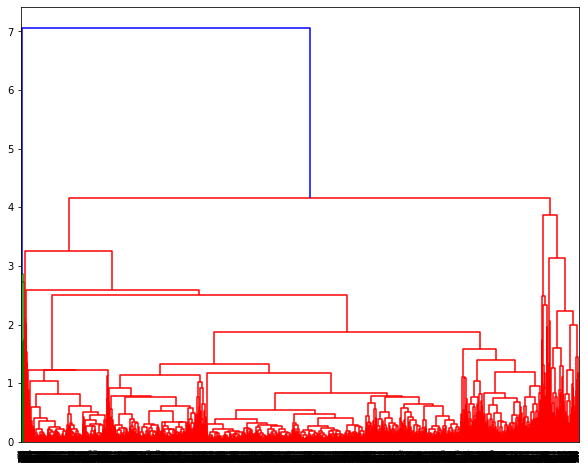

In [ ]:
# Average linkage

mergings = linkage(RFTr_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

Cutting Dendrogram by k

In [ ]:
# 2 clusters
cluster_labels = cut_tree(mergings, n_clusters=2).reshape(-1, )
cluster_labels

ag_cluster = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean')
ag_cluster.fit(RFTr_df_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [ ]:
# Assign cluster labels

RFTr['Cluster_Labels'] = cluster_labels
RFTr.head()

cluster_data= RFTr.copy()
cluster_data['cluster_pred'] = ag_cluster.fit_predict(RFTr_df_scaled)

In [ ]:
ag_cluster.labels_

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
cluster_data

,CustomerID,Frequency,TotalRevenue,Recency,Cluster_Id,Cluster_Labels,cluster_pred
0,12346.0,2,0.00,325,0,0,0
1,12347.0,182,4310.00,1,1,0,1
2,12348.0,31,1797.24,74,0,0,0
3,12349.0,73,1757.55,18,0,0,0
4,12350.0,17,334.40,309,0,0,0
...,...,...,...,...,...,...,...
4366,18278.0,9,173.90,73,0,0,0
4367,18280.0,10,180.60,277,0,0,0
4368,18281.0,7,80.82,180,0,0,0
4369,18282.0,13,176.60,7,0,0,0


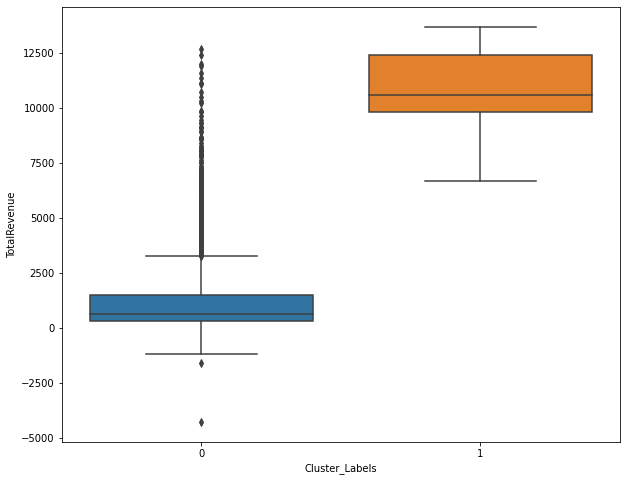

In [ ]:
# Plot Cluster Id vs TotalRevenue

sns.boxplot(x='Cluster_Labels', y='TotalRevenue', data=RFTr)

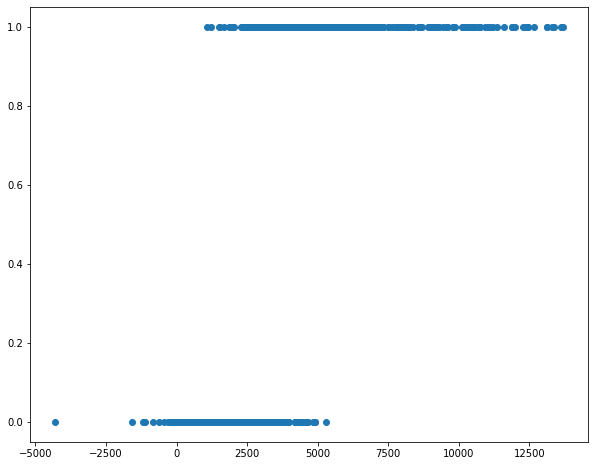

In [ ]:
plt.scatter(cluster_data['TotalRevenue'], cluster_data['cluster_pred'], cmap='rainbow')

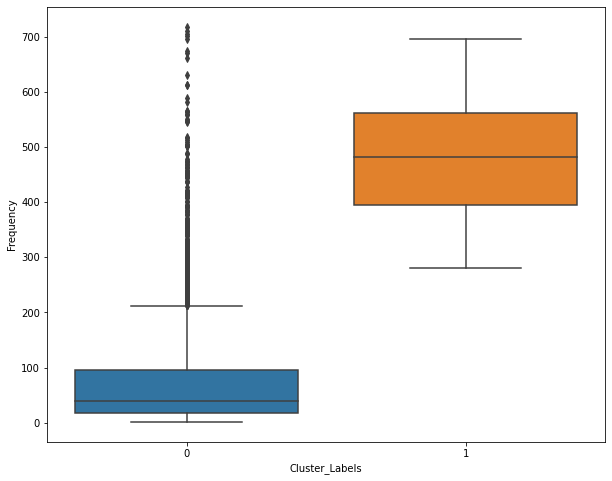

In [ ]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=RFTr)

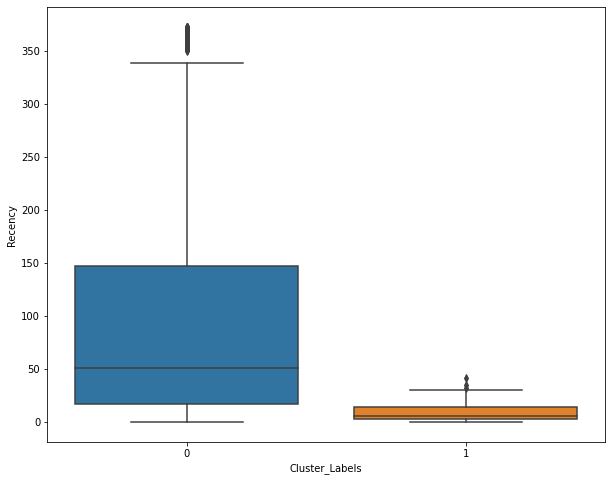

In [ ]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=RFTr)

<h1>Inference</h1>

K-Means Clustering with 2 Cluster Ids
- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 1 are recent buyers and hence of most importance from business point of view.

Hierarchical Clustering with 2 Cluster Ids
- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 1 are recent buyers and hence of most importance from business point of view.

**Customers with cluster id 1 are therefore customers of most importance.**